## install gdal

In [ ]:
# não está sendo necessário rodar
!apt-get update

In [ ]:
%%bash
apt-get install gdal-bin
Y
Y

In [ ]:
%%bash
apt-get install libgdal1i libgdal1-dev libgdal-dev
Y
Y

In [ ]:
# não está sendo necessário rodar
%%bash
apt install software-properties-common
Y
Y
add-apt-repository ppa:ubuntugis/ppa

In [10]:
# não está sendo necessário rodar
%%bash
export CPLUS_INCLUDE_PATH=/usr/include/gdal
export C_INCLUDE_PATH=/usr/include/gdal

In [ ]:
!gdal-config --version

In [ ]:
%%bash
pip install pygdal==2.1.3.3

In [ ]:
%%bash
apt-get install qgis
Y
Y

## import libraries

In [1]:
import ee
from IPython import display
import math
from matplotlib import pyplot as plt # para mostrar imagens ou gráficos
import numpy as np # para computação numérica menos intensiva
import pandas as pd
import seaborn as sns
from scipy import ndimage
from osgeo import gdal
import tempfile
import tensorflow as tf # para redes neurais
import urllib.request as urllib
import zipfile
import os

In [2]:
# cria uma pasta para colocar os dados
if not os.path.exists('tmp'):
    os.makedirs('tmp')

### Load Landsat image

In [ ]:
# BANDAS QUE SERÃO BAIXADAS
# ['B3', 'B4', 'B5', 'B6', 'B7']

### Download da imagem para treino e validação

In [193]:
!gsutil cp gs://tensorflow-fire-cerrado/train_test_fire_scene_22170_image1_out_2017.tif ./tmp/train_test_fire_scene_22170_image1_out_2017.tif



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying gs://tensorflow-fire-cerrado/train_test_fire_scene_22170_image1_out_2017.tif...
\ [1 files][ 27.8 MiB/ 27.8 MiB]                                                
Operation completed over 1 objects/27.8 MiB.                                     


### Download da imagem para classifição

In [ ]:
!gsutil cp gs://tensorflow-fire-cerrado/scene_22170_image2_set_2017.tif ./tmp/scene_22170_image2_set_2017.tif

In [3]:
def load_image(file):
    dataset = gdal.Open(file, gdal.GA_ReadOnly)
    return dataset
    
def convert_to_array(dataset):
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
    return np.stack(bands, 2)

### Read a imagem para treino e validação

In [4]:
file = './tmp/train_test_fire_scene_22170_image1_out_2017.tif'
dataset_train_test = load_image(file)
data_train_test = convert_to_array(dataset_train_test)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(data_train_test[:,:,[3,2,1]] * 3, 0, 1))
plt.show()

### Read a imagem para classifição

In [29]:
file = './tmp/scene_22170_image2_set_2017.tif'
dataset_classify = load_image(file)
data_classify = convert_to_array(dataset_classify)

### Preparar dados para o modelo

In [ ]:
# RESHAPE NOS DADOS DE "data_train_test" E "data_classify"

In [6]:
# Reshape into a single vector of pixels for data train and test
data_train_test_vector = data_train_test.reshape([data_train_test.shape[0] * data_train_test.shape[1], data_train_test.shape[2]])

# Reshape into a single vector of pixels for data classify
data_classify_vector = data_classify.reshape([data_classify.shape[0] * data_classify.shape[1], data_classify.shape[2]])

In [ ]:
# PARA CALCULAR A DIFERENÇA NORMALIZADA DE DUAS ENTRADAS

In [6]:
def normalizedDifference(a, b):
    nd = (a - b) / (a + b)
    nd_inf = (a - b) / (a + b + 0.000001)
    return np.where(np.isfinite(nd), nd, nd_inf)

In [7]:
def evi(a, b, c):
    e = 2.5 * (a - b) / (((a + 6) * b) - (7.5 * (c + 1)))
    return e

In [ ]:
# DADOS DE TREINO E TESTE: SELECIONA APENAS OS DADOS VÁLIDOS E EMBARALHA

In [8]:
valid_data_train_test = data_train_test_vector[~np.isnan(data_train_test_vector).any(axis=1)]
np.random.shuffle(valid_data_train_test)

In [ ]:
# CALCULA O NDVI PARA QUEIMA E NÃO QUEIMA E ADICIONA AO DADOS

In [ ]:
# index correspondente a cada banda
# 0->'B3', 1->'B4', 2->'B5', 3->'B6', 4->'B7', 5->'label'

In [9]:
# NDVI (B5 e B4)
NDVI = normalizedDifference(valid_data_train_test[:, 2], valid_data_train_test[:, 1]);

# NBR (B5 e B7)
NBR = normalizedDifference(valid_data_train_test[:, 2], valid_data_train_test[:, 4])

# EVI (B5, B4 e B2)
EVI = evi(valid_data_train_test[:, 2], valid_data_train_test[:, 1], valid_data_train_test[:, 0])

teste = NBR*NDVI

# adiciona o NDFI aos dados
valid_data_train_test = np.column_stack((valid_data_train_test, NDVI, NBR, EVI, teste))

In [ ]:
# agora, index correspondente a cada banda
# 0->'B3', 1->'B4', 2->'B5', 3->'B6', 4->'B7', 5->'label'
# 6->'NDVI', 7->'NBR', 8->'EVI', 9->'teste'

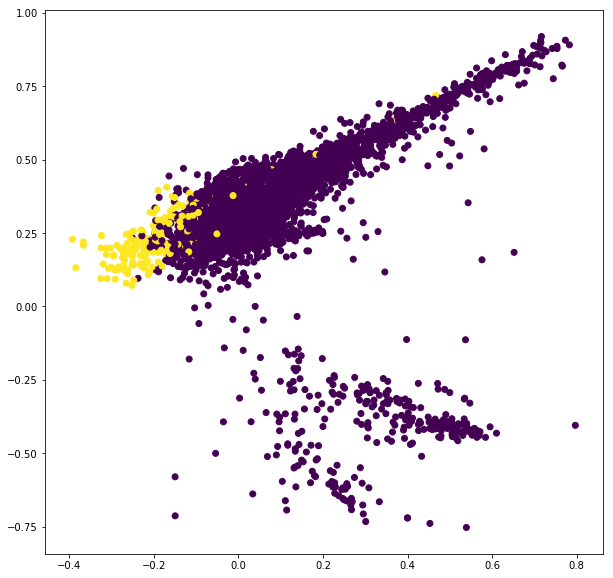

In [14]:
n_fire = valid_data_train_test[:5000, 6]
fire = valid_data_train_test[:5000, 7]
value = valid_data_train_test[:5000, 5]

plt.figure(figsize=(10, 10))
plt.scatter(fire, n_fire, c=value)
plt.show()

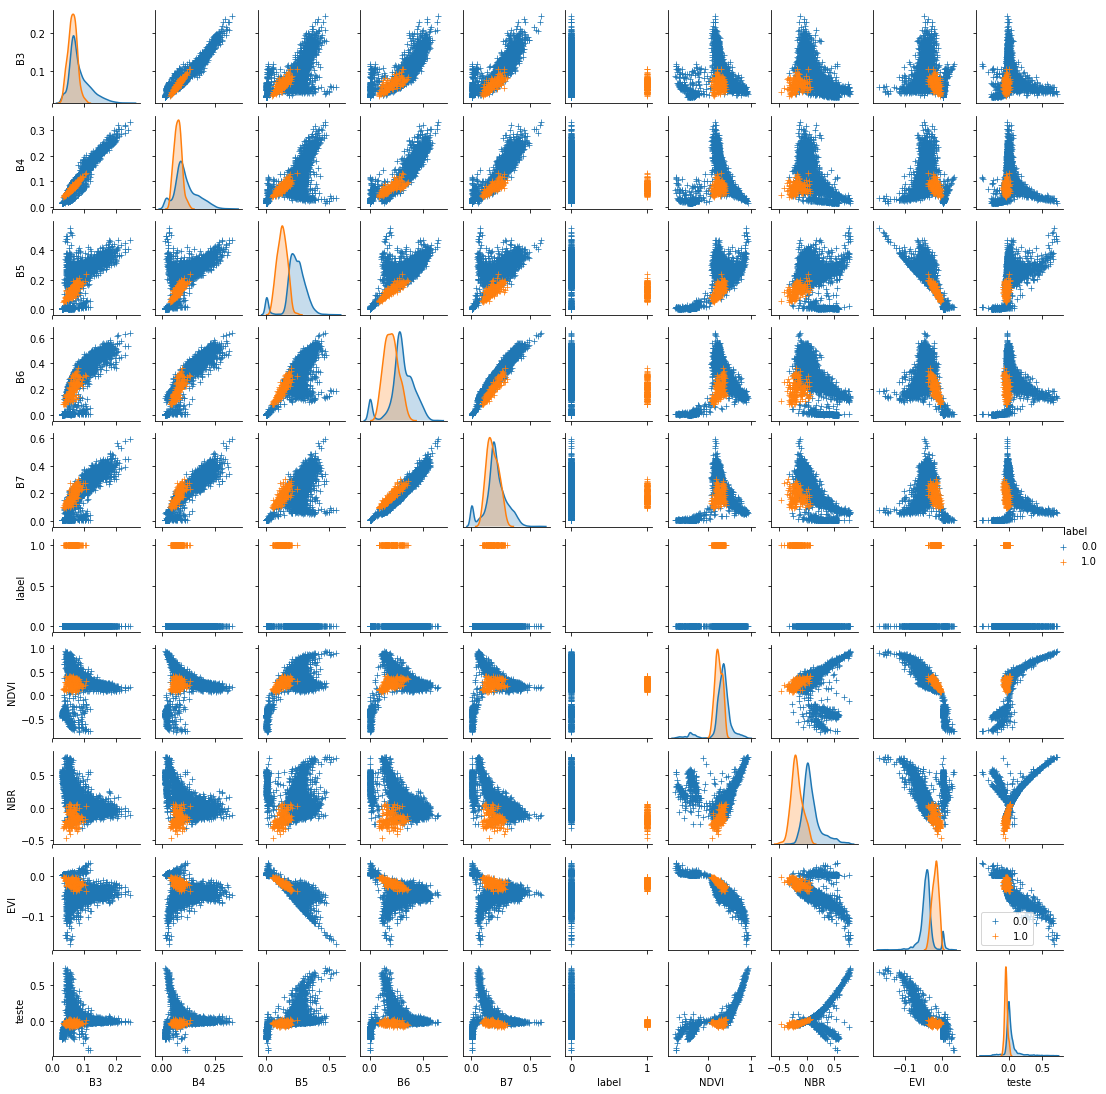

In [89]:
columns=['B3','B4','B5','B6','B7','label','NDVI','NBR','EVI','teste']

df = pd.DataFrame(valid_data_train_test[:5000,[0,1,2,3,4,5,6,7,8,9]],columns=columns)
#df["id"] = df.index

#sns.lmplot(x="id", y="NBR", data=df, hue="label", fit_reg=False, legend=False)

g = sns.pairplot(df, hue='label', markers='+')
g.fig.set_size_inches(15,15)

plt.legend()
plt.show()

In [203]:
# SELECIONA APENAS AS BANDAS QUE APRESENTARAM DIFERENÇA ENTRE QUEIMA E NÃO QUEIMA E O LABEL

In [15]:
valid_data_train_test = valid_data_train_test[:, [0,1,2,3,4,5,7,8]] # B3, B4, B5, B6, B7, LABEL, NBR e EVI

In [ ]:
# SEPARA OS DADOS ENTRE TREINO E VALIDAÇÃO

In [16]:
TRAIN_FRACTION = 0.7

# Hold out a fraction of the labeled data for validation
training_size = int(valid_data_train_test.shape[0] * TRAIN_FRACTION)
training_data= valid_data_train_test[0:training_size,:]
validation_data = valid_data_train_test[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands
data_mean = training_data[:,[0,1,2,3,4,6,7]].mean(0)
data_std = training_data[:,[0,1,2,3,4,6,7]].std(0)

In [ ]:
# HIPER-PARÂMETROS

In [17]:
lr = 0.001 # learning rate
BATCH_SIZE = 1000
N_ITER = 10000
NUM_INPUT = 7 # B3, B4, B5, B6, B7, NBR e EVI
NUM_N_L1 = 128
NUM_N_L2 = 64
NUM_N_L3 = 128
NUM_N_L4 = 64
NUM_N_L5 = 128
NUM_N_L6 = 64
NUM_N_L7 = 128
NUM_N_L8 = 64
NUM_N_L9 = 128
NUM_N_L10 = 64
NUM_N_L11 = 128
NUM_N_L12 = 64
NUM_N_L13 = 128
NUM_N_L14 = 64
NUM_N_L15 = 128
NUM_CLASSES = 2

In [ ]:
# CONSTRUÇÃO DO MODELO

In [18]:
def fully_connected_layer(input, n_neurons, activation=None):
    
    # variáveis da camada
    input_size = input.get_shape().as_list()[1]
    W = tf.Variable(tf.truncated_normal([input_size, n_neurons], stddev=1.0 / math.sqrt(float(input_size))))
    b = tf.Variable(tf.zeros([n_neurons]))

    # operação linear
    layer = tf.matmul(input, W) + b
    
    # aplica a não linearidade
    if activation == 'relu':
        layer = tf.nn.relu(layer)
    
    return layer

In [19]:
graph = tf.Graph() # cria um grafo
with graph.as_default(): # abre o grafo para adicionar os nós
    
    # camdas de inputs
    x_input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT])
    y_input = tf.placeholder(tf.int64, shape=[None])

    normalized = (x_input - data_mean) / data_std
    hidden1 = fully_connected_layer(normalized, n_neurons=NUM_N_L1, activation='relu')
    hidden2 = fully_connected_layer(hidden1, n_neurons=NUM_N_L2, activation='relu')
    hidden3 = fully_connected_layer(hidden2, n_neurons=NUM_N_L3, activation='relu')
    hidden4 = fully_connected_layer(hidden3, n_neurons=NUM_N_L4, activation='relu')
    hidden5 = fully_connected_layer(hidden4, n_neurons=NUM_N_L5, activation='relu')
    hidden6 = fully_connected_layer(hidden5, n_neurons=NUM_N_L6, activation='relu')
    hidden7 = fully_connected_layer(hidden6, n_neurons=NUM_N_L7, activation='relu')
    hidden8 = fully_connected_layer(hidden7, n_neurons=NUM_N_L8, activation='relu')
    hidden9 = fully_connected_layer(hidden8, n_neurons=NUM_N_L9, activation='relu')
    hidden10 = fully_connected_layer(hidden9, n_neurons=NUM_N_L10, activation='relu')
    hidden11 = fully_connected_layer(hidden10, n_neurons=NUM_N_L11, activation='relu')
    hidden12 = fully_connected_layer(hidden11, n_neurons=NUM_N_L12, activation='relu')
    hidden13 = fully_connected_layer(hidden12, n_neurons=NUM_N_L13, activation='relu')
    hidden14 = fully_connected_layer(hidden13, n_neurons=NUM_N_L14, activation='relu')
    hidden15 = fully_connected_layer(hidden14, n_neurons=NUM_N_L15, activation='relu')
    
    logits = fully_connected_layer(hidden15, n_neurons=NUM_CLASSES)

    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_input, name='error'))
    
    # otimizador
    optimizer = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    outputs = tf.argmax(logits, 1)

    correct_prediction = tf.equal(outputs, y_input)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # inicializador
    init = tf.global_variables_initializer()
    
    # para salvar o modelo de treino
    saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


In [198]:
# EXECUÇÃO DO MODELO

In [20]:
def show_chart_accuracy(arr_acc):
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(range(len(arr_acc)), arr_acc)
    plt.title('Accuracy')
    plt.ylabel('%')
    plt.xlabel('step x%d ' %(i/(N_ITER/100)))
    plt.grid(True)

    plt.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close() # clear the image of graphic

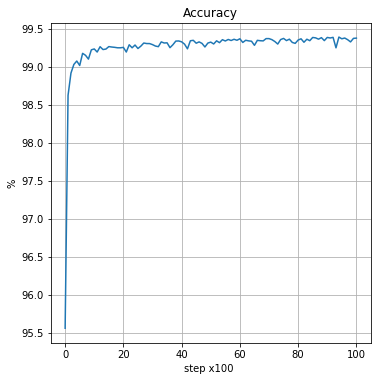

In [21]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
  
    validation_dict = {
        x_input: validation_data[:,[0,1,2,3,4,6,7]],
        y_input: validation_data[:, 5]
    }

    arr_acc = [];

    for i in range(N_ITER + 1):
        batch = training_data[np.random.choice(training_size, BATCH_SIZE, False), :]
        # cria o feed_dict de treino
        feed_dict = {
          x_input: batch[:,[0,1,2,3,4,6,7]], 
          y_input: batch[:, 5]
        }
        # executa a interação de treino
        optimizer.run(feed_dict=feed_dict)

        if i % 100 == 0:
            # calcula a acurácia
            acc = accuracy.eval(validation_dict) * 100
            
            # adiciona no array o valor da acurácia de cada passo
            arr_acc.append(acc)
            
            # mostra o gráfico de acurácia
            show_chart_accuracy(arr_acc)
            
            # salva as variávies do modelo
            saver.save(sess, './tmp/deep_ann.ckpt')

            #print('Accuracy %.2f%% at step %s' %(acc, i))

In [70]:
# FAZ A PREDIÇÃO

In [31]:
# NDVI (B5 e B4)
NDVI = normalizedDifference(data_classify_vector[:, 2], data_classify_vector[:, 1]);

# NBR (B5 e B7)
NBR = normalizedDifference(data_classify_vector[:, 2], data_classify_vector[:, 4])

# EVI (B5, B4 e B2)
EVI = evi(data_classify_vector[:, 2], data_classify_vector[:, 1], data_classify_vector[:, 0])

teste = NBR*NDVI

data_classify_vector = np.column_stack((data_classify_vector, NDVI, NBR, EVI, teste))

In [32]:
print(data_classify_vector.shape)

(14111920, 9)


In [33]:
with tf.Session(graph=graph) as sess:
    ## B3, B4, B5, B6, B7, LABEL, NBR, EVI e teste
    # restaura o valor das variáveis
    saver.restore(sess, './tmp/deep_ann.ckpt')
    
    arr = [0,1,2,3,4,6,7]
      
    # faz a classificação - divide em cinco partes para evitar "Kernel memory"
    output_data_classify0 = outputs.eval({x_input: data_classify_vector[:4000000, arr]})
    output_data_classify1 = outputs.eval({x_input: data_classify_vector[4000000:8000000, arr]})
    output_data_classify2 = outputs.eval({x_input: data_classify_vector[8000000:12000000, arr]})
    output_data_classify3 = outputs.eval({x_input: data_classify_vector[12000000:, arr]})
    
    output_data_classify = np.concatenate([
                                        output_data_classify0,
                                        output_data_classify1,
                                        output_data_classify2,
                                        output_data_classify3
                           ])
    
    print('Done classify...')

INFO:tensorflow:Restoring parameters from ./tmp/deep_ann.ckpt
Done classify...


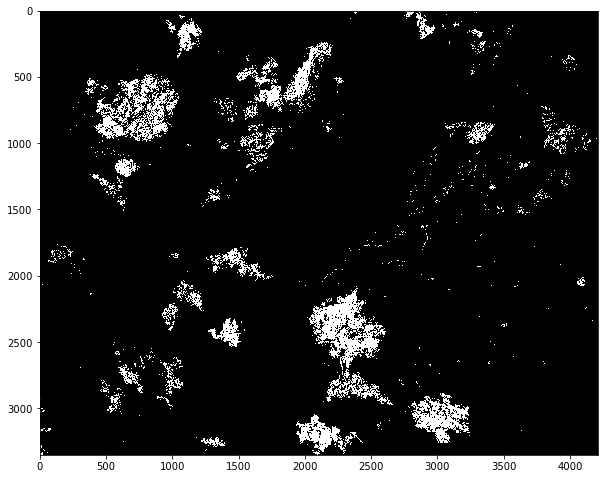

In [34]:
output_image = output_data_classify.reshape([data_classify.shape[0], data_classify.shape[1]])

plt.figure(figsize=(10,10))
plt.imshow(output_image, cmap='gray')
plt.show()

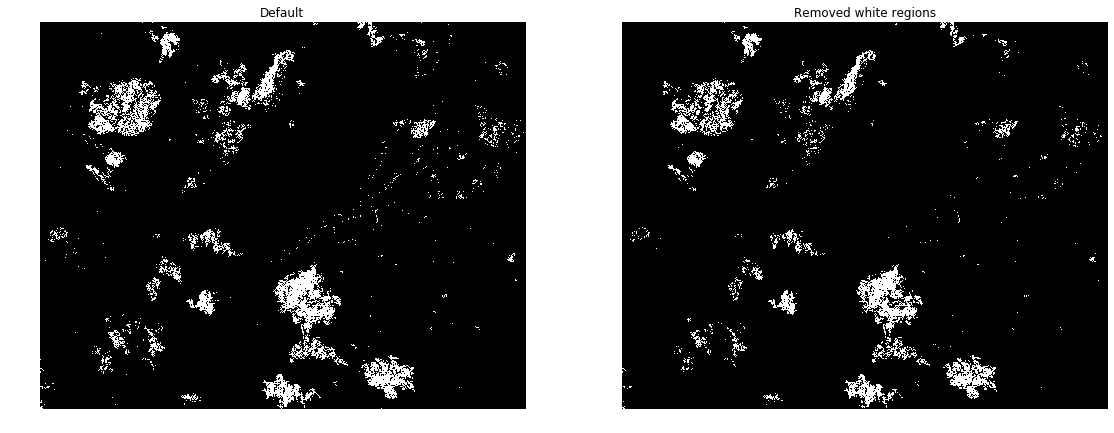

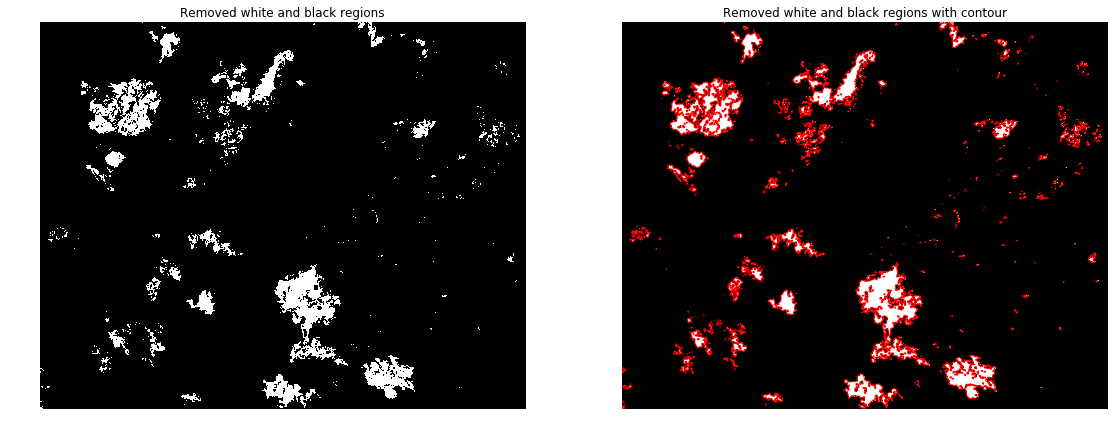

In [35]:
binary_image = output_image > 0

# Remove small white regions
open_image = ndimage.binary_opening(binary_image, structure=np.ones((3,3)))
# Remove small black hole
close_image = ndimage.binary_closing(open_image, structure=np.ones((8,8)))

plt.figure(figsize=(40, 10))

plt.subplot(141)
plt.title('Default')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.title('Removed white regions')
plt.imshow(open_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(40, 10))

plt.subplot(143)
plt.title('Removed white and black regions')
plt.imshow(close_image, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.title('Removed white and black regions with contour')
plt.imshow(close_image, cmap='gray')
plt.contour(close_image, [0.5], linewidths=1, colors='r')
plt.axis('off')

plt.show()


In [36]:
cols = dataset_classify.RasterXSize
rows = dataset_classify.RasterYSize
ds = dataset_classify

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create("outimage.tif", cols, rows, 1, gdal.GDT_Float32)
outDs.GetRasterBand(1).WriteArray(close_image)

# follow code is adding GeoTranform and Projection
geotrans=ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=ds.GetProjection() #you can get from a exsited tif or import 
outDs.SetGeoTransform(geotrans)
outDs.SetProjection(proj)
outDs.FlushCache()
outDs=None

In [37]:
!gsutil cp ./outimage.tif gs://tensorflow-fire-cerrado

Copying file://./outimage.tif [Content-Type=image/tiff]...
\ [1 files][ 53.9 MiB/ 53.9 MiB]  235.6 KiB/s                                   
Operation completed over 1 objects/53.9 MiB.                                     


In [38]:
outputAssetID = 'users/derllikowski/mapping_fire_scene2_22170_set_2017_1'

!earthengine upload image --asset_id={outputAssetID} gs://tensorflow-fire-cerrado/outimage.tif

Started upload task with ID: LEINXRTS5UKH2MY3MMY2J2GR
